---

# Premium Bonds distribution

|  |  |
| ---: | :----------- |
| Author | S. Menary [sbmenary@gmail.com] |
| Date | 18/3/2023 (last update 20/3/2023) |
| Brief | Using the monthly prize distribution, throw toys to work out the distribution of returns after `n` months |

---

# Introduction

We want to estimate the expected distribution of returns from buying Premium Bonds. We know that the mean annual return is $\sim 3.3\%$, but we also know that this includes a sparse tail of very large returns (up to £1m). Also, due to the stochastic nature of the draw, we expect the distribution to have some natural variance. This means:
- if we don't own many bonds, it is possible that the most-likely return is actually 0\%
- since the mean is pulled upwards by the large-but-unlikely prize values, the median return may be lower than 3.3\%
- in general, our actual return will be a random draw from a distribution, and we want to know what that distribution looks like
- we want to know how many bonds to buy to ensure that the variance around the median expected return is tolerable

Prizes are drawn monthly, and we know the prize distribution for each £1 bond. To turn this into a distribution of $n$-month compound returns, we have a combinatoric problem of order $N^{n}$, which quickly becomes computationally intractable. Instead we estimate the distribution by throwing toys.

The remainder of this notebook will implement the toys and derive the expected distribution of Premium Bond returns.

---

# 1. Imports & reproducibility

Let us import all the packages we will need, and print their versions for reproducibility.

---

In [1]:
###
###   Imports
###   -  all package imports go here unless there is a very good reason otherwise
###

##  Python stdlib
import math, sys, time

##  PyPI packages
import numpy      as np
import pandas     as pd
import matplotlib as mpl

##  Individual modules / objects
from matplotlib import pyplot as plt
from pathlib    import Path


In [2]:
###
###   Print package versions for reproducibility
###

print( "   Package | Version")
print( "-----------+" + "-"*90)
print(f"    Python | {sys.version}")
print(f"     Numpy | {np.__version__}")
print(f"    Pandas | {pd.__version__}")
print(f"Matplotlib | {mpl.__version__}")

   Package | Version
-----------+------------------------------------------------------------------------------------------
    Python | 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
     Numpy | 1.23.2
    Pandas | 1.5.3
Matplotlib | 3.6.3


---

# 2. Data definition

The only input data we need are:
- the monthly prize distribution
- the odds of winning a prize

These numbers allow us to simulate the monthly prize draw every month. This allows us to generate a toy distribution of expected returns after `n` months.

We take this data from https://www.nsandi.com/get-to-know-us/monthly-prize-allocation. The odds of a single `£1` bond winning a prize are `1:24,000`. The algorithm for deciding how many of each prize value to allocate each month is a little arcane, and the resulting prize distribution changes very little month-to-month. To make our lives easier, we will just scrape the prize distribution from Feb 2023 and consider this to be representative of the prize distribution for all months. We expect this to be a very good approximation.

The prize distribution is as follows:

---

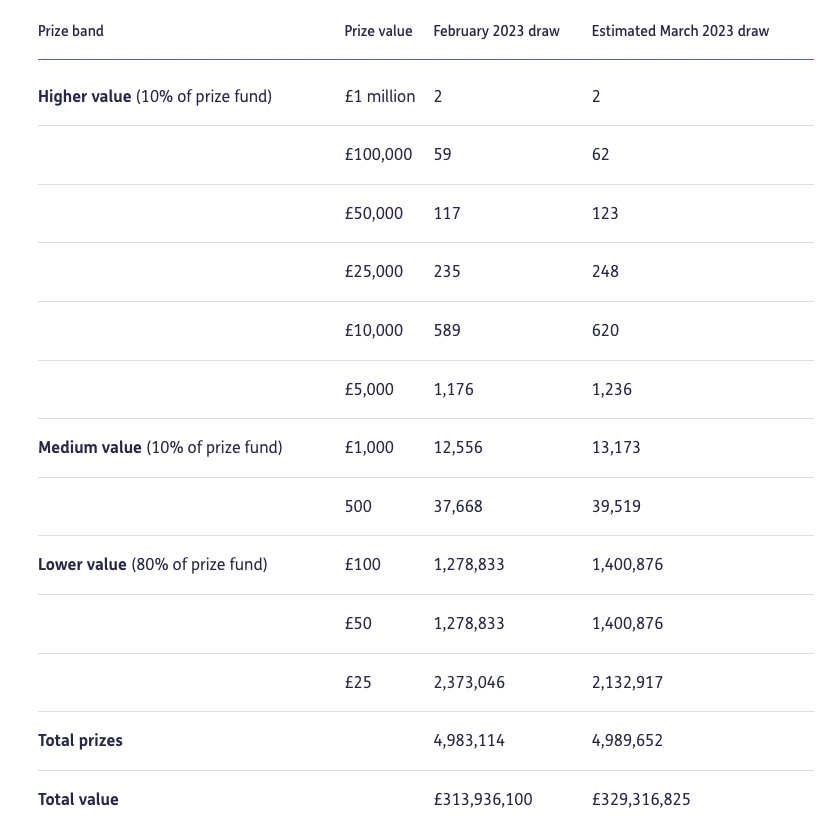

In [3]:
###
###   Config
###   -  Define input data 
###   -  Data source: https://www.nsandi.com/get-to-know-us/monthly-prize-allocation
###

##  Prize value : Number of prizes allocated in Feb 2023
prizes_feb23 = {
    25    : 2373046,
    50    : 1278833,
    100   : 1278833,
    500   : 37668,
    1e3   : 12556,
    5e3   : 1176,
    1e4   : 589 ,
    2.5e4 : 235 ,
    5e4   : 117 ,
    1e5   : 59  ,
    1e6   : 2   ,
}

##  Odds of a £1 bond winning a prize in Feb 2023
odds_feb23 = 1. / 24000.


---

# 3. Data preprocessing & visualisation

We will simply visualise our data as a table. We do this by loading it into a `pandas DataFrame`. We will also cross-check that we reproduce the advertised mean growth rate of $\sim 3.3\%$.

---

In [4]:
###
###  Data preprocessing
###

##  Determine approximately how many bonds did not win a prize in Feb 2023
num_zero_prize    = sum(prizes_feb23.values()) * (1. / odds_feb23 - 1)

##  Create numpy arrays of our prze values and numbers, including the zero prizes
prize_vals_feb23  = np.array([0] + list(prizes_feb23.keys())               , dtype=np.int32)
prize_nums_feb23  = np.array([num_zero_prize] + list(prizes_feb23.values()), dtype=np.float32)

##  Convert absolute prize numbers into probabilities
prize_probs_feb23 = (prize_nums_feb23 / prize_nums_feb23.sum()).astype(np.float32)

##  Create DataFrame from our numpy arrays
##  - DataFrame object allows us to name our columns
df_prizes_feb23 = pd.DataFrame(
    {
    "prize_val"    : prize_vals_feb23 ,
    "monthly_num"  : prize_nums_feb23 ,
    "monthly_prob" : prize_probs_feb23,
    }
)

##  Insert additional column for the fractional monthly growth
df_prizes_feb23.insert(3, "monthly_growth", 
                       df_prizes_feb23.prize_val * df_prizes_feb23.monthly_prob)

##  Insert additional column for the fractional monthly growth as a multiplicative factor
df_prizes_feb23.insert(4, "monthly_growth_fac", 
                       1 + df_prizes_feb23.monthly_growth)

##  Insert additional column for the fractional monthly growth as a multiplicative factor
df_prizes_feb23 = df_prizes_feb23.astype(
    {
    "prize_val"          : np.int32  ,
    "monthly_num"        : np.float32,
    "monthly_prob"       : np.float32,
    "monthly_growth"     : np.float32,
    "monthly_growth_fac" : np.float32,
    }
)

In [5]:
###
###  Data visualisation
###  -  the simplest way to quickly understand this data is to print it
###

df_prizes_feb23

,prize_val,monthly_num,monthly_prob,monthly_growth,monthly_growth_fac
0,0,1.195898e+11,9.999583e-01,0.000000,1.000000
1,25,2.373046e+06,1.984239e-05,0.000496,1.000496
2,50,1.278833e+06,1.069305e-05,0.000535,1.000535
3,100,1.278833e+06,1.069305e-05,0.001069,1.001069
4,500,3.766800e+04,3.149637e-07,0.000157,1.000157
5,1000,1.255600e+04,1.049879e-07,0.000105,1.000105
6,5000,1.176000e+03,9.833209e-09,0.000049,1.000049
7,10000,5.890000e+02,4.924966e-09,0.000049,1.000049
8,25000,2.350000e+02,1.964969e-09,0.000049,1.000049
9,50000,1.170000e+02,9.783039e-10,0.000049,1.000049



### Cross-check expected annual return

From the website, we know that the expected annual return is $\sim 3.3\%$. We should be able to reproduce this using the numbers provided. We will use this cross-check to validate our input numbers.

We allow for some variation around the $3.3\%$ because of how the prize draw is calculated for any given month. 


In [6]:
###
###  Cross-check
###  - estimate the expected annual growth factor as (total monthly growth factor)^12
###  - we expect this to be ~3.3% for the numbers provided for Feb 2023
###

##  total monthly growth obtained by summing over all prize values
tot_monthly_growth = df_prizes_feb23.monthly_growth.sum()

##  total monthly growth factor
monthly_growth_fac = 1 + tot_monthly_growth

##  annual growth factor
annual_growth_fac  = monthly_growth_fac ** 12

##  annual growth
annual_growth      = annual_growth_fac - 1

##  
print(f"CROSS CHECK:  Based on input data, expected annual growth is ~ {100.*annual_growth:.2f}%  \
[should be ~ 3.3% but allow some variation]")


CROSS CHECK:  Based on input data, expected annual growth is ~ 3.20%  [should be ~ 3.3% but allow some variation]


---

# 5. Throw toys

---

In [7]:
###
###  Configure
###

start_amount = 1000      ##  Number of £1 bonds owned at start
num_months   = 12*1      ##  Number of months to simulate per-toy
num_toys     = 100000    ##  Number of toys experiments to run


In [8]:
###
###  Define method for throwing toys
###

def get_toy_return_factor(start_amount:int, num_months:int, num_toys:int=1) -> np.ndarray :
    '''
    Function: get_toy_return_factors
    
    Brief: Obtain many samples from the distribution of return factors by running toy experiments.
    
    Inputs:
    
        >  start_amount, int
           Number of £1 bonds to begin with
           
        >  num_months, int
           Number of months to simulate for each toy experiment
           
        >  num_toys, int, default=1
           Number of toy experiments to run
           
    Returns
    
        >  Array of shape (num_toys,)
           Return factor obtained for each toy
    '''
    
    ##  create container for toy values
    returns = []

    ##  perform toy experiments
    ##  - once per month, randomly generate a return for each bond owned and add it to the total
    ##  - do this for the number of months requested
    start_time = time.time()
    for toy_idx in range(num_toys) :
        if (toy_idx+1) % 100 == 0 :
            sys.stdout.write(f"\rProcessing toy {1+toy_idx} / {num_toys} [t={time.time()-start_time:.1f}s]")
        toy_amount = start_amount
        for month_idx in range(num_months) :
            bond_returns = 1 + np.random.choice(prize_vals_feb23, size=toy_amount, p=prize_probs_feb23)
            toy_amount = bond_returns.sum()
        returns.append(toy_amount)

    ##  convert to np array and normalise by start value
    returns = np.array(sorted(returns), dtype=np.float32)
    returns /= float(start_amount)
    
    ##  return
    return returns
    

In [9]:
###
###  Perform toy experiments
###

print(f"Obtaining {num_toys} toy return factors for {start_amount} bonds over {num_months} months")
toy_return_factors = get_toy_return_factor(start_amount, num_months, num_toys)


Obtaining 100000 toy return factors for 1000 bonds over 12 months
Processing toy 100000 / 100000 [t=49.0s]

---

# 6. Process toy results

Our toys told us the distribution of fractional $n$-month returns $R_n$ (i.e. a growth of 3% corresponds to a factor of $1.03$). We will now convert these into several useful quantities:
1. effective annual returns $R_{12}$, using the formula $R_{12} = \exp\left(\frac{12}{n}\log R_n\right)$
2. absolute returns, equal to $R_x - 1$

We will then calculate the mean and median of these quantities.

Finally we will use the _bootstrap_ method to estimate a $67\%$ confidence band on the mead and median.

---

In [10]:
###
###  Calculate annual and absolute growth
###


##  Use log-formula to calculate equivalent annual return factors
print(f"Converting toy return factors to annual equivalent")
toy_annual_return_factors = np.exp(12*np.log(toy_return_factors)/num_months)


##  Convert return factors to absolute return (e.g. growth factor of 1.03 is an absolute growth of 0.03)
print(f"Converting toy return factors to absolute growth")
toy_returns        = toy_return_factors - 1.
toy_annual_returns = toy_annual_return_factors - 1.


Converting toy return factors to annual equivalent
Converting toy return factors to absolute growth


In [11]:
###
###  Calculate mean and median returns
###

total_return_mean    = np.mean  (toy_returns)
total_return_median  = np.median(toy_returns)
print(f"  Mean {num_months}-month return is {100.*total_return_mean  :.2f}%  (from toys)")
print(f"Median {num_months}-month return is {100.*total_return_median:.2f}%  (from toys)\n")

annual_return_mean   = np.mean  (toy_annual_returns)
annual_return_median = np.median(toy_annual_returns)
print(f"  Mean annual return is {100.*annual_return_mean  :.2f}%  (from toys)")
print(f"Median annual return is {100.*annual_return_median:.2f}%  (from toys)")

  Mean 12-month return is 3.22%  (from toys)
Median 12-month return is 0.00%  (from toys)

  Mean annual return is 3.22%  (from toys)
Median annual return is 0.00%  (from toys)


In [12]:
###
###  Do bootstraps
###  - use to estimate confidence bands around the estimate mean and median
###

##  Configure number of bootstraps
num_bs = 100

##  Loop over bootstraps - for each bs, re-draw random samples from the toys and re-calculate mean/median
bs_means, bs_medians = [], []
for bs_idx in range(num_bs) :
    bs_indcs = np.random.randint(low=0, high=num_toys, size=(num_toys,))
    bs_annual_returns = toy_annual_returns[bs_indcs]
    bs_medians.append(np.median(bs_annual_returns))
    bs_means  .append(np.mean  (bs_annual_returns))
    
##  Get mean and std dev from bootstrap distributions
annual_return_mean_bs_mean   = np.mean(bs_means  )
annual_return_median_bs_mean = np.mean(bs_medians)
annual_return_mean_bs_std    = np.std (bs_means  )
annual_return_median_bs_std  = np.std (bs_medians)
    
##  Print results
print(f"median annual return  {100*annual_return_median_bs_mean:.2f} +- {100*annual_return_median_bs_std:.2f} %")
print(f"  mean annual return  {100*annual_return_mean_bs_mean  :.2f} +- {100*annual_return_mean_bs_std  :.2f} %")


median annual return  0.00 +- 0.00 %
  mean annual return  3.23 +- 0.10 %


- Since our probability distribution is discrete, if we run enough toys then all of our bootstraps will have the same median, and the std dev collapses to zero
- If we run enough toys, then the std dev on the mean also becomes very small

---

# 7. Plot results

Plot the distribution of toys
- on the LHS we plot the probability density function, PDF
- on teh RHS we plot the cumulative distribution function, CDF

---

In [13]:
###
###  Define method for creating plot
###

def make_plot(returns, start_amount, num_months, mean, mean_std, median, median_std, savefig=None) :
    '''
    Create and show a plot of the PDF and CDF, using the toy data provided
    '''

    ##  Figure out sensible x-axis limits
    max_return = 5*median if median > 0 else returns[int(0.95*len(returns))]
    max_return = max_return if max_return > 0.01 else 0.01 
    
    ##  Configure binning
    bins       = np.linspace(0, max_return, 51)
    bin_width  = bins[1] - bins[0]
    
    ##  Create CDF y-axis values
    cdf        = np.linspace(1/len(returns), 1, len(returns))

    ##  Create plot figure
    fig = plt.figure(figsize=(12, 4))
    fig.subplots_adjust(wspace=0.5)

    ##  Create & format LHS axis
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.tick_params(which="both", axis="both", direction="in", top=True, right=True, labelsize=11)
    ax1.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
    ax1.axvline(mean  , c="darkorange", lw=3)
    ax1.axvline(median, c="darkred"   , lw=3)
    ax1.set_xlabel("Expected Annual Return", ha="center", rotation=0, fontsize=15, labelpad=20)
    ax1.set_ylabel("PDF\n[1 per %]", ha="right", rotation=0, fontsize=15, labelpad=20)
    ax1.set_xlim([0, max_return])
    
    ##  Draw text for LHS axis
    ax1.text(0.95, 0.95, f"start with {start_amount:,} bonds", ha="right", va="top", transform=ax1.transAxes, fontsize=11)
    ax1.text(0.95, 0.86, f"median: {100*median:.2f} +- {100*median_std:.2f} %", ha="right", va="top", transform=ax1.transAxes, fontsize=11, c="darkred")
    ax1.text(0.95, 0.77, f"mean: {100*mean:.2f} +- {100*mean_std:.2f} %", ha="right", va="top", transform=ax1.transAxes, fontsize=11, c="chocolate", weight="bold")
    ax1.text(0, 1.21, "Premium Bonds expected returns", ha="left", va="bottom", transform=ax1.transAxes, fontsize=15, c="k", weight="bold")
    ax1.text(0, 1.18, f"Toy analysis following prize distribution @ Feb 2023, run for {num_months} months", ha="left", va="top", transform=ax1.transAxes, fontsize=11, c="k", style="italic")

    ##  Create & format RHS axis
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.tick_params(which="both", axis="both", direction="in", top=True, right=True, labelsize=11)
    ax2.yaxis.set_ticks(np.linspace(0, 1, 41), minor=True )
    ax2.yaxis.set_ticks(np.linspace(0, 1, 11), minor=False)
    ax2.xaxis.set_ticks(np.linspace(0, 0.12, 25), minor=True)
    ax2.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
    ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
    ax2.grid(which="major", lw=1, ls="-", c="darkgray")
    ax2.grid(which="minor", lw=0.5, ls=":", c="gray")
    ax2.set_xlabel("Expected Annual Return", ha="center", rotation=0, fontsize=15, labelpad=20)
    ax2.set_ylabel("CDF", ha="right", rotation=0, fontsize=15, labelpad=20)
    ax2.set_xlim([0, max_return])
    ax2.set_ylim([0, 1])

    ##  Draw PDF
    ax1.hist(returns, bins=bins, density=True, alpha=0.7)

    ##  Draw CDF
    ax2.plot(returns, cdf, "-", lw=3)

    ##  Draw table of CDF values next to RHS axis
    for x_idx, x in enumerate(np.linspace(0.05, 0.95, 19)) :
        ax2.text(1.05, x_idx/19, f"{round(100*(1-x)):02d}%:  $\geq$ {100*np.interp(x, cdf, returns):.2f}%", 
                 ha="left", va="bottom", transform=ax2.transAxes, fontsize=9.5,
                 weight = "bold" if x>0.49 and x<0.51 else None)

    ##  If savefig is a string then interpret as a filename and save figure
    if type(savefig) is str :
        Path("/".join(savefig.split("/")[:-1])).mkdir(parents=True, exist_ok=True)
        plt.savefig(savefig, bbox_inches="tight", dpi=150)
        
    ##  If savefig is a string then interpret as a list of filenames and save figure
    if type(savefig) is list :
        for f_savefig in savefig :
            Path("/".join(f_savefig.split("/")[:-1])).mkdir(parents=True, exist_ok=True)
            plt.savefig(f_savefig, bbox_inches="tight", dpi=150)
            
    ##  Show figure
    plt.show(fig)
    
    ##  Close figure
    plt.close(fig)
    

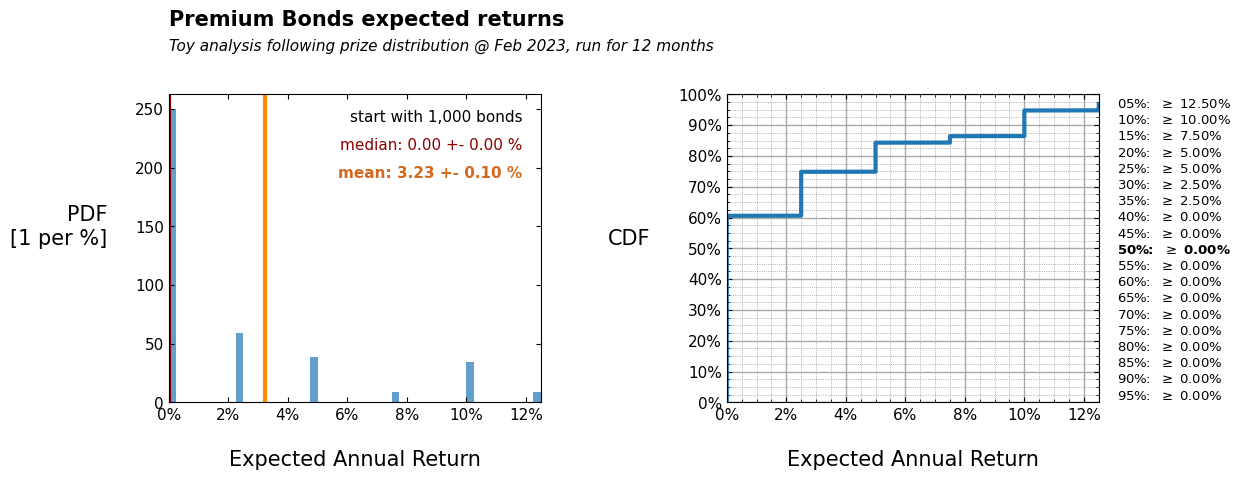

In [14]:
###
###  Plot PDF and CDF
###

make_plot(toy_annual_returns, start_amount, num_months,
          annual_return_mean_bs_mean, annual_return_mean_bs_std, 
          annual_return_median_bs_mean, annual_return_median_bs_std,
          savefig=[f"figures/premium_bonds_toy_analysis_{start_amount}bonds.pdf",
                   f"figures/premium_bonds_toy_analysis_{start_amount}bonds.png"])
